#### Imports and plot format

In [1]:
# execute if not installed
import sys
import os
sys.path.insert(0, '../')

import mogptk

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

%reload_ext autoreload
%autoreload 2

In [2]:
os.makedirs('output', exist_ok=True)

In [3]:
# plot config
sns.set_context('paper', font_scale=1.3)
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (10, 5)

# Mauna Loa

Experiment of CO2 measurements in Mauna Loa using single output Gaussian process with Spectral Mixture Kernel.

In [4]:
# dataset mauna loa
from sklearn.datasets import fetch_openml

# function to load dataset
def load_mauna_loa_atmospheric_co2():
    ml_data = fetch_openml(data_id=41187)
    months = []
    ppmv_sums = []
    counts = []

    y = ml_data.data[:, 0]
    m = ml_data.data[:, 1]
    month_float = y + (m - 1) / 12
    ppmvs = ml_data.target

    for month, ppmv in zip(month_float, ppmvs):
        if not months or month != months[-1]:
            months.append(month)
            ppmv_sums.append(ppmv)
            counts.append(1)
        else:
            # aggregate monthly sum to produce average
            ppmv_sums[-1] += ppmv
            counts[-1] += 1

    months = np.asarray(months).reshape(-1)
    avg_ppmvs = np.asarray(ppmv_sums) / counts
    return months, avg_ppmvs

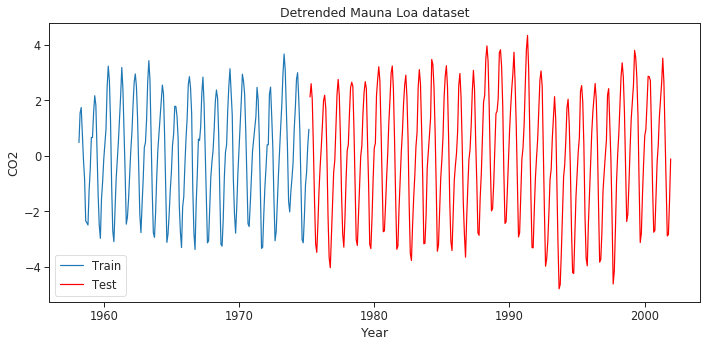

In [5]:
x, y_old = load_mauna_loa_atmospheric_co2()

# detrend 
poly = np.polyfit(x, y_old, 3)
y = y_old - np.polyval(poly, x)

trend = y_old - y
stop = 200

# plot
plt.plot(x[:stop], y[:stop], label='Train')
plt.plot(x[stop:], y[stop:], 'r', label='Test')
plt.legend()
plt.xlabel('Year')
plt.ylabel('CO2');
plt.title('Detrended Mauna Loa dataset')
plt.tight_layout();

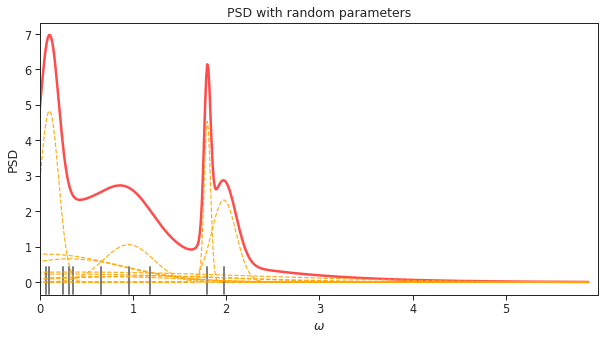

In [6]:
# add data
data = mogptk.Data()
data.add(x[:stop], y[:stop])

# create model
model = mogptk.SM(data, Q=10)

mogptk.plot_psd(model, title='PSD with random parameters')

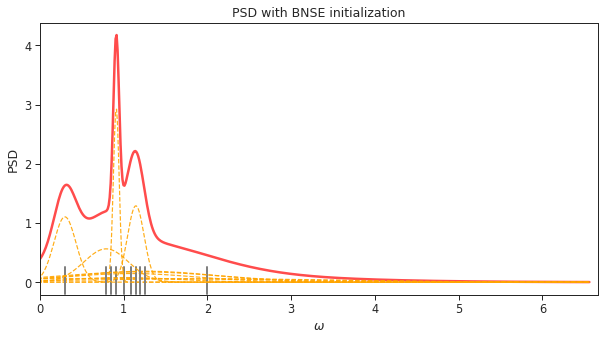

In [7]:
method = 'BNSE'
model.init_params(method)

mogptk.plot_psd(model, title='PSD with {} initialization'.format(method))

Building...
Optimizing...
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 55.010243
  Number of iterations: 114
  Number of functions evaluations: 135
Done


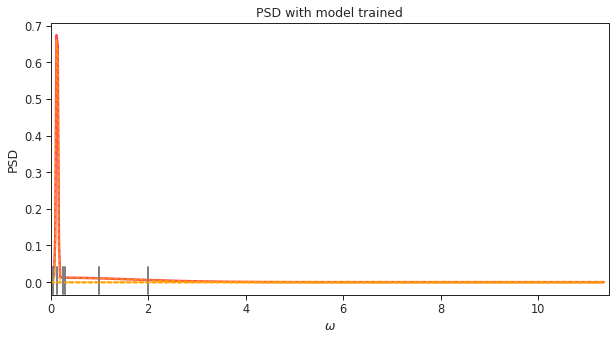

CPU times: user 1.22 s, sys: 100 ms, total: 1.32 s
Wall time: 1.18 s


In [10]:
%%time 
model.train(method='L-BFGS-B', maxiter=3000, disp=True, learning_rate=0.001)

mogptk.plot_psd(model, title='PSD with model trained')

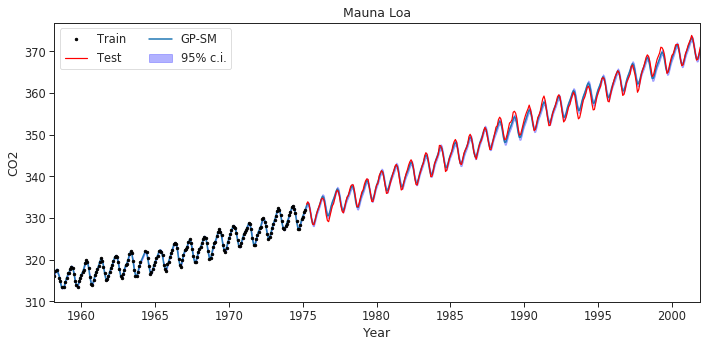

In [9]:
# prediction
x_pred = {0:x[:, np.newaxis]}
x_pred, y_pred, y_var = model.predict(x_pred)

# plot
plt.plot(x[:stop], trend[:stop] + y[:stop], '.k', label='Train')
plt.plot(x[stop:], trend[stop:] + y[stop:], '-r', label='Test')
plt.plot(x_pred[0], trend + y_pred[0], lw=1.5, zorder=1, label='GP-SM')
plt.fill_between(x_pred[0].reshape(-1),
                 trend + y_pred[0] + 2 * np.sqrt(y_var[0]),
                 trend + y_pred[0] - 2 * np.sqrt(y_var[0]),
                 color='b',
                 alpha=0.3,
                 zorder=1,
                 label='95% c.i.')
plt.legend(ncol=2)
plt.title('Mauna Loa')
plt.xlabel('Year')
plt.ylabel('CO2')
plt.xlim(x[0], x[-1])
plt.tight_layout();

# Air Quality MOGP

Experiment on multioutput ussing the mogptk toolbox.

2. __CO(GT)__ True hourly averaged concentration CO in mg/m^3 (reference analyzer)
3. __PT08.S1(CO)__ PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted)
4. __NMHC(GT)__ True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer)
5. __C6H6(GT)__ True hourly averaged Benzene concentration in microg/m^3 (reference analyzer)
6. __PT08.S2(NMHC)__ PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)
7. __NOx(GT)__ True hourly averaged NOx concentration in ppb (reference analyzer)
8. __PT08.S4(NO2)__ PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted)
9. __NO2(GT)__ True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)
10. __PT08.S4(NO2)__ PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)
11. __PT08.S5(O3)__ PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted)
12. __T__ Temperature in Â°C
13. __RH__ Relative Humidity (%)
14. __AH__ AH Absolute Humidity 

__Load and Pre-processing__

In [11]:
# load
df = pd.read_csv('data/AirQualityUCI.csv', delimiter=';')

# last 2 columns are only nans
df = df.iloc[:, :-2]

# drop the rows with nan values
df.dropna(inplace=True)

# First 2 columns are date and time, we convert it to a single column with datetime format
dates = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S')

# create column with datetime values
df['timedate'] = dates

# define a initial date to compare all other to
ini_date = pd.Timestamp('2004-03-10 00:00:00.0')

# get elapsed hours
df['time'] = (dates - ini_date) / pd.Timedelta(hours=1)

# drop useless columns
df.drop(columns=['Time', 'Date'], inplace=True)

In [12]:
df.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,timedate,time
0,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,2004-03-10 18:00:00,18.0
1,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,2004-03-10 19:00:00,19.0
2,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,2004-03-10 20:00:00,20.0
3,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,2004-03-10 21:00:00,21.0
4,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,2004-03-10 22:00:00,22.0


We check the number of missing values per column, registered as -200 (minimun value of the sensor)

In [13]:
(df == -200).sum(0)

CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
timedate            0
time                0
dtype: int64

### mogptk data structure

MOGP toolbox uses the following structure:
Given $m$ channels, each one with its inputs $x_i$ and output $y_i$, $i=1,\ldots,m$. The toolbox uses to train

* dict of inputs $x$.
* dict of outputs $y$.

## Data to use

* As outputs we will use the ground thruth of: CO, NMHC, C6H6, NOx, NO2
* I a first experiment will only use time as input.

For this we will use the mogptk.Data class, which allows to use the different models in the toolbox.

In [14]:
# we use the first 200 rows, the first 3 days
n_experiment = 200
ini_t = 300
df2 = df.iloc[ini_t:n_experiment + ini_t]

In [15]:
# columns to use
cols = ['CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']

# class for storing data
data = mogptk.Data()

for i, c in enumerate(cols):
    # index of non-missing values
    idx = (df2[c] != -200)
    
    print('Channel {} with {} non-missing values'.format(c, idx.sum()))
    
    # add data to the model
    x = df2['time'][idx].values
    y = df2[c][idx].values
    
    data.add(x, y)

print('Points per channel:', data.get_channel_sizes())

Channel CO(GT) with 196 non-missing values
Channel NMHC(GT) with 200 non-missing values
Channel C6H6(GT) with 200 non-missing values
Channel NOx(GT) with 192 non-missing values
Channel NO2(GT) with 192 non-missing values
Points per channel: [196, 200, 200, 192, 192]


__Remove random portions of the data to simulate sensor failure__

In [16]:
# randomly sample from the data
for i in range(5):
    data.remove_randomly(channel=i, pct=0.7)

# drop chunks to simulate sensor failure
data.remove_range(0, 425, 460)
data.remove_range(1, 480, None)
data.remove_range(2, 480, None)
data.remove_range(3, 480, None)
data.remove_range(4, None, 350)

create a function for plotting the experiment

In [17]:
def plot_air_experiment(x_train=None,
                        y_train=None,
                        x_all=None,
                        y_all=None,
                        x_pred=None,
                        y_pred=None,
                        var_pred=None,
                        ylims=None,
                        cols=cols,
                        title=''):
    """
    5x1 Plot for the Air quality experiment
    """
    if ylims is None:
        ylims = [(-1, 7), (-60, 900), (-5, 32), (-50, 380), (10, 170)]
        
    f, axarray = plt.subplots(5, 1, sharex=True, figsize=(12, 10))

    for i in range(5):
        # plot post mean
        if (x_pred is not None) & (y_pred is not None):
            axarray[i].plot(x_pred[i] ,y_pred[i], label='Post.Mean', c=sns.color_palette()[i])
            
        # error bars
        if (x_pred is not None) & (y_pred is not None) & (var_pred is not None):
            axarray[i].fill_between(x_pred[i].reshape(-1),
                                    y_pred[i] + 2 * np.sqrt(var_pred[i]),
                                    y_pred[i] - 2 * np.sqrt(var_pred[i]),
                                    alpha=0.3,
                                    label='95% c.i.',
                                    color=sns.color_palette()[i]
                                   )
        # plot trainning points
        if (x_train is not None) & (y_train is not None):
            axarray[i].plot(x_train[i], y_train[i], '.k', ms=6, label='Training points')
            
        # plot ground truth will all data
        if (x_all is not None) & (y_all is not None):
            axarray[i].plot(x_all[i], y_all[i], '--k', label='All data', alpha=0.7)

        axarray[i].set_ylabel(cols[i][:-4])
        axarray[i].set_ylim(ylims[i])

    plt.legend(fontsize=12, ncol=4, bbox_to_anchor=(0.35, 5.65, 0.5, 0.5))
    plt.xlabel('Hours')
    plt.xlim(df2['time'].values[0] - 1, df2['time'].values[-1] + 1)
    plt.suptitle(title, y=0.95)

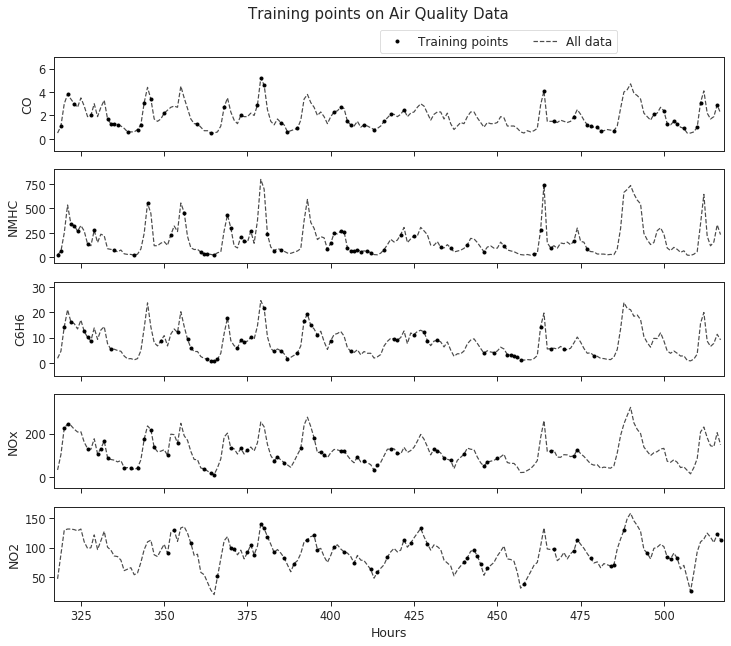

In [18]:
title='Training points on Air Quality Data'

plot_air_experiment(x_train=data.X,
                    y_train=data.Y,
                    x_all=data.X_all,
                    y_all=data.Y_all,
                    title=title
                   )

# 1. Independant GP with SM kernel (IGP)

In [19]:
# Spectral Mixture kernel
Q = 5 # number of mixtures
D = 1 # input dim

# prediction inputs
x_pred = np.linspace(df2['time'].values[0], df2['time'].values[-1], 500)
x_pred = {0:x_pred[:, np.newaxis]}

mean_list = []
var_list = []

model_list = []

# metric containers
igp_mae = np.zeros(5)
igp_mape = np.zeros(5)
igp_mse = np.zeros(5)

for i in range(5):
    
    data_single = mogptk.Data()
    data_single.add(data.X[i], data.Y[i])
    
    # first get the sm kernel params set
    model = mogptk.SM(data_single, Q=Q)
    model.init_params('random')
    # model.init_params('LS')
    model.train(method='Adam', maxiter=3000, disp=False, tol=1e-30)
    
    # predict
    x, mean, var = model.predict(x_pred)
    
    mean_list.append(mean[0].reshape(-1))
    var_list.append(var[0].reshape(-1))
    
    model_list.append(model)
    
    # ERROR METRICS
    # predict on all data input 
    
    # generate inputs in the same points as the training set
    idx = df2[cols[i]] != -200
    X_pred = {0:(df2['time'][idx].values)[:, np.newaxis]}
    
    x, mean, var = model.predict(X_pred)
    
    diff = mean[0] - df2[cols[i]][idx].values
    
    igp_mae[i] = np.abs(diff).mean()
    igp_mape[i] = (np.abs(diff) / df2[cols[i]][idx].values * 100).mean()
    igp_mse[i] = (diff**2).mean()

pd.DataFrame(np.c_[igp_mae, igp_mape, igp_mse], columns=['MAE', 'MAPE', 'MSE'])

,MAE,MAPE,MSE
0,0.584060,39.245913,0.560119
1,80.598407,66.072147,19478.828213
2,3.358151,52.569572,27.379945
3,43.369933,41.402624,4153.048377
4,15.549491,17.675989,548.478446


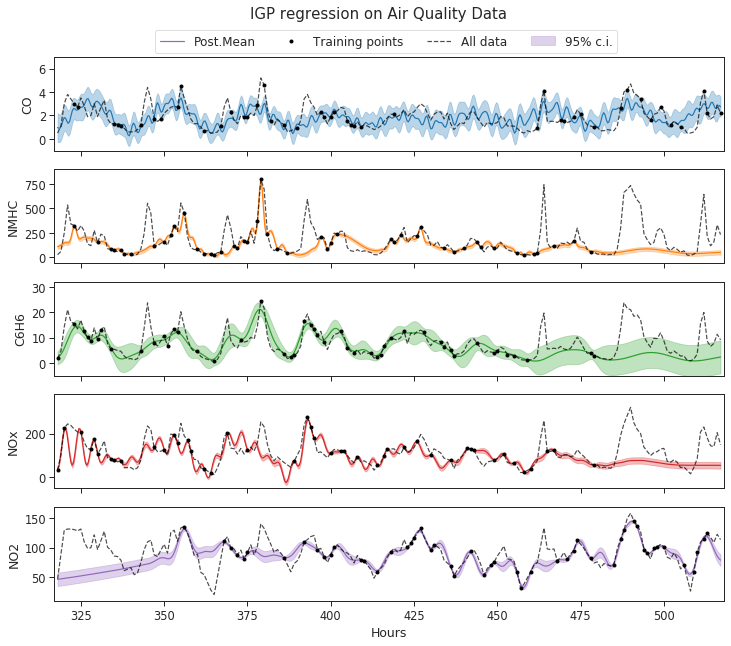

In [19]:
title = 'IGP regression on Air Quality Data'

# duplicate x_pred to satisfy function format
x_pred = np.linspace(df2['time'].values[0], df2['time'].values[-1], 500)
x_pred = [x_pred for i in range(5)]

plot_air_experiment(x_train=data.X,
                    y_train=data.Y,
                    x_all=data.X_all,
                    y_all=data.Y_all,
                    x_pred=x_pred,
                    y_pred=mean_list,
                    var_pred=var_list,
                    title=title
                   )
# plt.savefig('output/air_quality_igp.pdf', bbox_inches='tight')

# 2. Multioutput Spectral Mixture (MOSM)

In [20]:
model_mosm = mogptk.MOSM(data, Q=4)
model_mosm.init_params('means')

__Optimice__

In [21]:
%%time
model_mosm.train(method='L-BFGS-B', maxiter=5000, learning_rate=0.001, disp=True, tol=1e-15)

Building...
Optimizing...
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 877.301208
  Number of iterations: 5000
  Number of functions evaluations: 5338
Done
CPU times: user 11min 1s, sys: 48.6 s, total: 11min 49s
Wall time: 8min 47s


__Predict on all hours and plot__

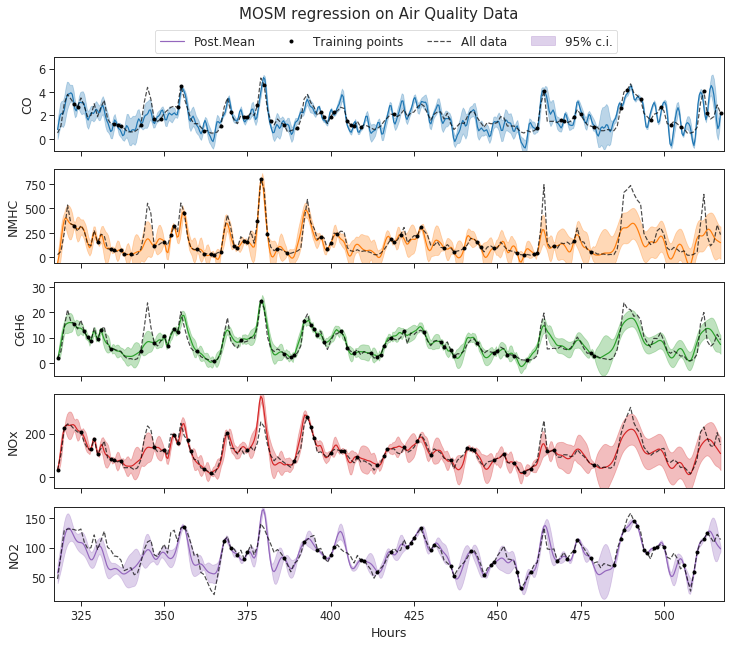

In [22]:
n_res = 500

for i in range(5):
    model_mosm.set_prediction_range(i, df2['time'].values[0], df2['time'].values[-1], n=n_res)

# predict
x_pred, y_pred, var_pred = model_mosm.predict()

# plot
title = 'MOSM regression on Air Quality Data'

plot_air_experiment(x_train=data.X,
                    y_train=data.Y,
                    x_all=data.X_all,
                    y_all=data.Y_all,
                    x_pred=x_pred,
                    y_pred=y_pred,
                    var_pred=var_pred,
                    title=title
                   )
# plt.savefig('output/air_quality_mosm.pdf', bbox_inches='tight')

### Get error metrics per channel

* Mean absolute error per channel (MAE)
* Mean absolute percentual error per channel (MAPE)
* Mean squared error per channel (MSE)

In [24]:
# convert data to dict
x_pred = {i:array for i, array in enumerate(data.X_all)}

# predict
x_pred, y_pred, var_pred = model_mosm.predict(x_pred)

# obtain erros
mosm_mae = np.zeros(5)
mosm_mape = np.zeros(5)
mosm_mse = np.zeros(5)

# errors per channel
for i in range(5):
    idx = df2[c] != -200
    mosm_mae[i] = np.abs(data.Y_all[i] - y_pred[i]).mean() # MAE
    mosm_mape[i] = np.abs((data.Y_all[i] - y_pred[i]) / data.Y_all[i] * 100).mean() # MAPE
    mosm_mse[i] = ((data.Y_all[i] - y_pred[i])**2).mean() # MSE
    
pd.DataFrame(np.c_[mosm_mae, mosm_mape, mosm_mse], columns=['MAE', 'MAPE', 'MSE'])

,MAE,MAPE,MSE
0,0.389979,28.233297,0.334710
1,54.123003,42.217392,9790.284063
2,1.509663,28.296293,6.114896
3,16.939273,15.199739,791.732019
4,8.889086,10.919022,178.912497


# 3. Cross Spectral Mixture (CSM)

In [41]:
model_csm = mogptk.CSM(data, Q=4)
# model_csm.init_params()

In [42]:
model_csm.train(method='L-BFGS-B', maxiter=5000, learning_rate=0.001, tol=1e-15)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1033.434066
  Number of iterations: 333
  Number of functions evaluations: 423


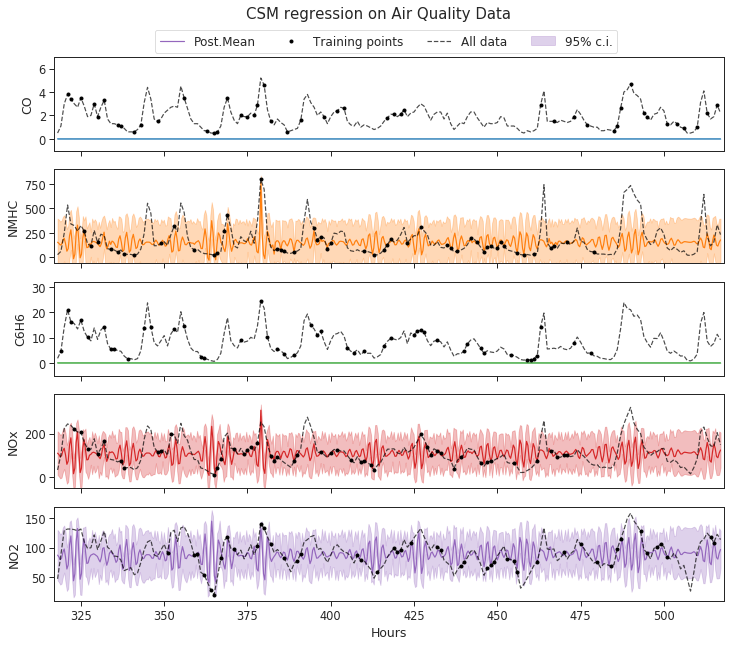

In [43]:
n_res = 500
for i in range(5):
    model_csm.set_prediction_range(i, df2['time'].values[0], df2['time'].values[-1], n=n_res)

# predict
x_pred, y_pred, var_pred = model_csm.predict()

# plot
title = 'CSM regression on Air Quality Data'

plot_air_experiment(x_train=data.X,
                    y_train=data.Y,
                    x_all=data.X_all,
                    y_all=data.Y_all,
                    x_pred=x_pred,
                    y_pred=y_pred,
                    var_pred=var_pred,
                    title=title
                   )
# plt.savefig('output/air_quality_csm.pdf', bbox_inches='tight')

In [44]:
# convert data to dict
x_pred = {i:array for i, array in enumerate(data.X_all)}

# predict
x_pred, y_pred, var_pred = model_csm.predict(x_pred)

# obtain erros
csm_mae = np.zeros(5)
csm_mape = np.zeros(5)
csm_mse = np.zeros(5)

# errors per channel
for i in range(5):
    idx = df2[c] != -200
    csm_mae[i] = np.abs(data.Y_all[i] - y_pred[i]).mean() # MAE
    csm_mape[i] = np.abs((data.Y_all[i] - y_pred[i]) / data.Y_all[i] * 100).mean() # MAPE
    csm_mse[i] = ((data.Y_all[i] - y_pred[i])**2).mean() # MSE
    
pd.DataFrame(np.c_[csm_mae, csm_mape, csm_mse], columns=['MAE', 'MAPE', 'MSE'])

,MAE,MAPE,MSE
0,1.882287,99.822362,4.512523
1,67.610491,55.910271,14340.181748
2,7.915097,99.947072,91.366439
3,23.994060,26.632723,1477.417411
4,9.091017,11.473492,178.418723


# 4. Spectral Mixture - Linear Model of Corregionalization (SM-LMC)

In [45]:
model_smlmc = mogptk.SM_LMC(data, Q=4)
model_smlmc.init_params()

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -235.744243
  Number of iterations: 15
  Number of functions evaluations: 25
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -30.484420
  Number of iterations: 42
  Number of functions evaluations: 79
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -175.234423
  Number of iterations: 105
  Number of functions evaluations: 127
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -66.524296
  Number of iterations: 122
  Number of functions evaluations: 148
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -109.483599
  Number of iterations: 33
  Number of functions evaluations: 5

In [46]:
model_smlmc.train(method='L-BFGS-B', maxiter=5000, learning_rate=0.001, tol=1e-15)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 826.997544
  Number of iterations: 5000
  Number of functions evaluations: 5443


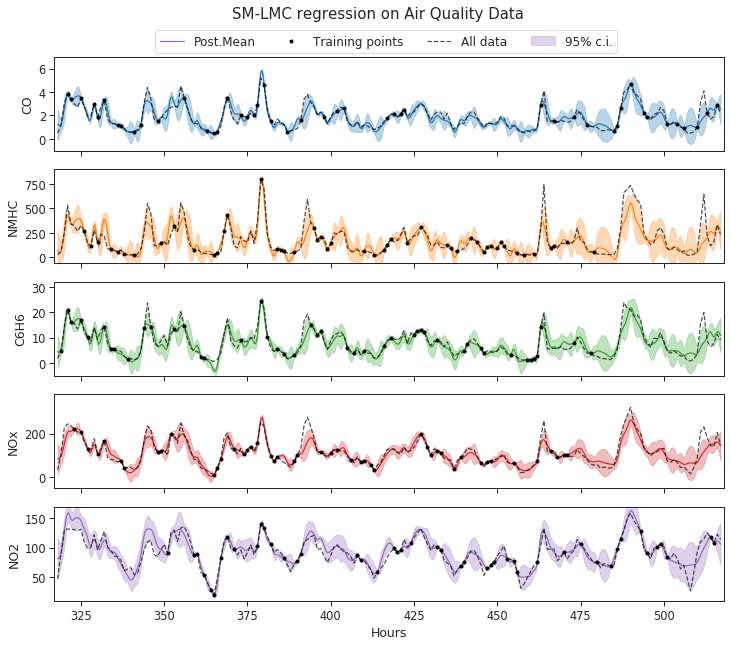

In [47]:
n_res = 500

for i in range(5):
    model_smlmc.set_prediction_range(i, df2['time'].values[0], df2['time'].values[-1], n=n_res)

# predict
x_pred, y_pred, var_pred = model_smlmc.predict()

# pLot
title = 'SM-LMC regression on Air Quality Data'

plot_air_experiment(x_train=data.X,
                    y_train=data.Y,
                    x_all=data.X_all,
                    y_all=data.Y_all,
                    x_pred=x_pred,
                    y_pred=y_pred,
                    var_pred=var_pred,
                    title=title
                   )
# plt.savefig('output/air_quality_smlmc.pdf', bbox_inches='tight')

In [48]:
# convert data to dict
x_pred = {i:array for i, array in enumerate(data.X_all)}

# predict
x_pred, y_pred, var_pred = model_csm.predict(x_pred)

# obtain erros
smlmc_mae = np.zeros(5)
smlmc_mape = np.zeros(5)
smlmc_mse = np.zeros(5)

# errors per channel
for i in range(5):
    idx = df2[c] != -200
    smlmc_mae[i] = np.abs(data.Y_all[i] - y_pred[i]).mean() # MAE
    smlmc_mape[i] = np.abs((data.Y_all[i] - y_pred[i]) / data.Y_all[i] * 100).mean() # MAPE
    smlmc_mse[i] = ((data.Y_all[i] - y_pred[i])**2).mean() # MSE
    
pd.DataFrame(np.c_[smlmc_mae, smlmc_mape, smlmc_mse], columns=['MAE', 'MAPE', 'MSE'])

,MAE,MAPE,MSE
0,1.882287,99.822362,4.512523
1,67.610491,55.910271,14340.181748
2,7.915097,99.947072,91.366439
3,23.994060,26.632723,1477.417411
4,9.091017,11.473492,178.418723


# 5. Convolutional Gaussian (CONV)

In [49]:
model_conv = mogptk.CG(data, Q=4)
# model_conv.init_params()

In [50]:
model_conv.train(method='L-BFGS-B', maxiter=5000, learning_rate=0.001, tol=1e-15)

ValueError: slice index 1 of dimension 0 out of bounds. for 'GPR-27bdb739-718/likelihood_1/strided_slice_14' (op: 'StridedSlice') with input shapes: [1,5], [2], [2], [2] and with computed input tensors: input[1] = <1 0>, input[2] = <2 0>, input[3] = <1 1>.

In [ ]:
n_res = 500

for i in range(5):
    model_conv.set_prediction_range(i, df2['time'].values[0], df2['time'].values[-1], n=n_res)

# predict
x_pred, y_pred, var_pred = model_conv.predict()

# pLot
title = 'CONV regression on Air Quality Data'

plot_air_experiment(x_train=data.X,
                    y_train=data.Y,
                    x_all=data.X_all,
                    y_all=data.Y_all,
                    x_pred=x_pred,
                    y_pred=y_pred,
                    var_pred=var_pred,
                    title=title
                   )
# plt.savefig('output/air_quality_conv.pdf', bbox_inches='tight')

In [ ]:
# convert data to dict
x_pred = {i:array for i, array in enumerate(data.X_all)}

# predict
x_pred, y_pred, var_pred = model_csm.predict(x_pred)

# obtain erros
conv_mae = np.zeros(5)
conv_mape = np.zeros(5)
conv_mse = np.zeros(5)

# errors per channel
for i in range(5):
    idx = df2[c] != -200
    conv_mae[i] = np.abs(data.Y_all[i] - y_pred[i]).mean() # MAE
    conv_mape[i] = np.abs((data.Y_all[i] - y_pred[i]) / data.Y_all[i] * 100).mean() # MAPE
    conv_mse[i] = ((data.Y_all[i] - y_pred[i])**2).mean() # MSE
    
pd.DataFrame(np.c_[conv_mae, conv_mape, conv_mse], columns=['MAE', 'MAPE', 'MSE'])